In [1]:
import numpy as np 
import pyxu.experimental.xray as pxr
import pyxu.opt.stop as pxst
import matplotlib.pyplot as plt
import xrt_splines
import pat_xrt
import matplotlib
import cupy as cp
from cupyx.profiler import benchmark
from skimage.transform import iradon
from scipy.signal import convolve2d as spconv
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from skimage.metrics import peak_signal_noise_ratio as psnr

cp.cuda.Device(0).use()

<CUDA Device 0>

In [2]:
def set_operators_parallel_beam(N_side, N_angle, N_offset, pitch_op, arg_shape):
    # Let's build the necessary components to instantiate the operator . ========================
    angles = np.linspace(0, np.pi, N_angle, endpoint=False)

    n = np.stack([np.cos(angles), np.sin(angles)], axis=1)
    pitch = 1.
    t        = n[:, [1, 0]] * np.r_[-1, 1]  # <n, t> = 0
    t_max    = pitch * (N_side-1) / 2 * 1.  # 10% over ball radius
    t_offset = np.linspace(-t_max, t_max, N_offset, endpoint=True)

    n_spec  = np.broadcast_to(n.reshape(N_angle, 1, 2), (N_angle, N_offset, 2))  # (N_angle, N_offset, 2)
    t_spec  = t.reshape(N_angle, 1, 2) * t_offset.reshape(N_offset, 1)  # (N_angle, N_offset, 2)
    t_spec += pitch * N_side / 2  # Move anchor point to the center of volume.
    extra   = np.ones((1,N_angle*N_offset,1))
    origin  = (0., 0.)
    pitch   = (1.,1.)

    t_spec  = cp.array(t_spec)
    n_spec  = cp.array(n_spec)

    op_splines_1 = xrt_splines.RayXRT(
        deg=1,
        arg_shape=arg_shape,
        t_spec=t_spec.reshape(-1,2), 
        n_spec=n_spec.reshape(-1,2),
        origin=origin,
        pitch=pitch_op,
    )
    op_splines_2 = xrt_splines.RayXRT(
        deg=2,
        arg_shape=arg_shape,
        t_spec=t_spec.reshape(-1,2), 
        n_spec=n_spec.reshape(-1,2),
        origin=origin,
        pitch=pitch_op,
    )
    op_pixels = pxr.XRayTransform.init(
        arg_shape=arg_shape,
        t_spec=t_spec.reshape(-1,2), 
        n_spec=n_spec.reshape(-1,2),
        origin=origin,
        pitch=pitch_op,
    )

    return op_pixels, op_splines_1, op_splines_2

def create_phantom(N_side):
    xx = np.linspace(-N_side//2,N_side//2, num=N_side)
    yy = xx
    X, Y = np.meshgrid(xx,yy)
    r = 700
    mask = np.sqrt(X**2 + Y**2) < r
    phantom = np.exp(-((X-517)**2 + (Y+429)**2)/400000) + 0.5*np.exp(-((X+673)**2 + (Y-687)**2)/400000)
    return cp.array(phantom)

/home/haouchat/cryo-ct/xrt_splines.py:210: PrecisionWarning: Only Width.SINGLE-precision inputs are supported: casting.
  warnings.warn(msg, pxw.PrecisionWarning)
/home/haouchat/miniconda3/envs/pyxu/lib/python3.11/site-packages/pyxu/experimental/xray/_rt.py:208: PrecisionWarning: Only Width.SINGLE-precision inputs are supported: casting.
  warnings.warn(msg, pxw.PrecisionWarning)
/home/haouchat/miniconda3/envs/pyxu/lib/python3.11/site-packages/pyxu/experimental/xray/_rt.py:208: PrecisionWarning: Only Width.SINGLE-precision inputs are supported: casting.
  warnings.warn(msg, pxw.PrecisionWarning)
/home/haouchat/cryo-ct/xrt_splines.py:210: PrecisionWarning: Only Width.SINGLE-precision inputs are supported: casting.
  warnings.warn(msg, pxw.PrecisionWarning)


sample normal
norm diff splines :  16.651485183851182
norm diff pixels  :  101.36153438014593


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Oversampled
norm diff splines :  231.72496391112807
norm diff pixels  :  1223.5242317514899
79.46211910712137
8.455191297787737


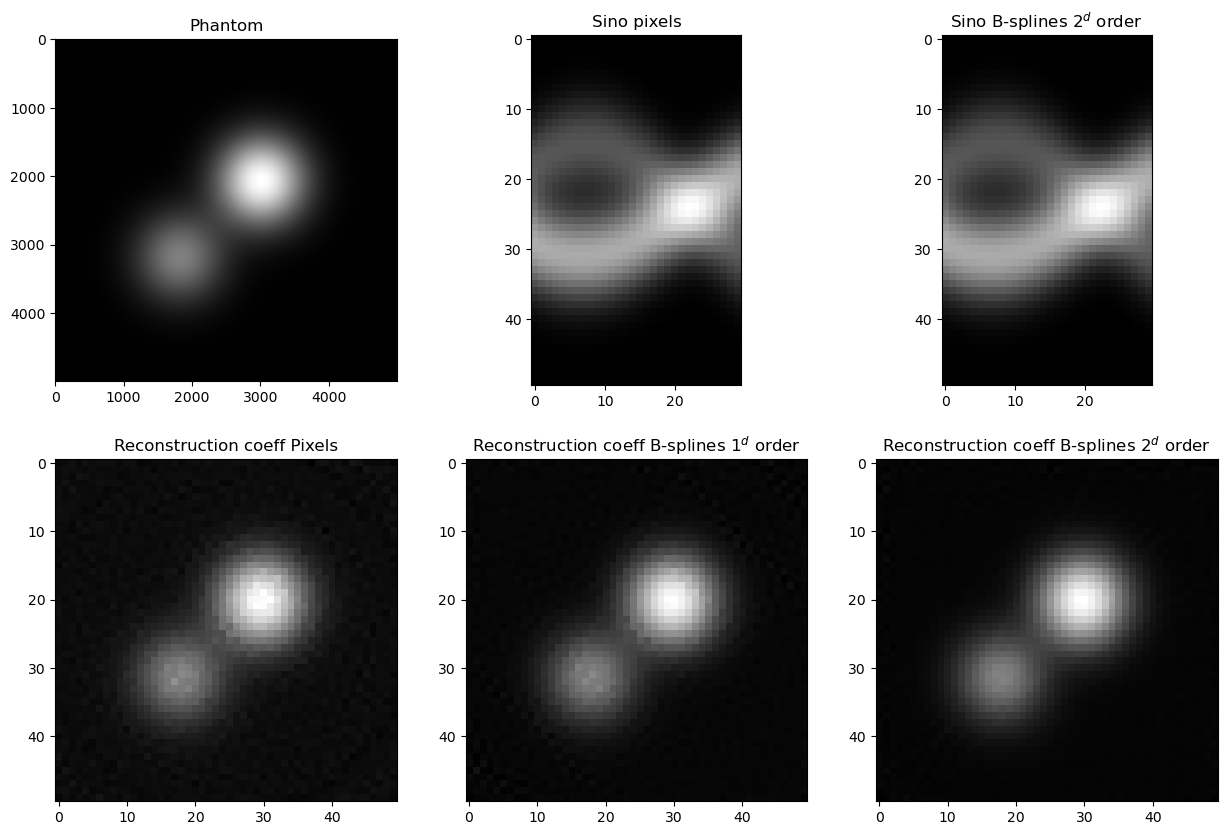

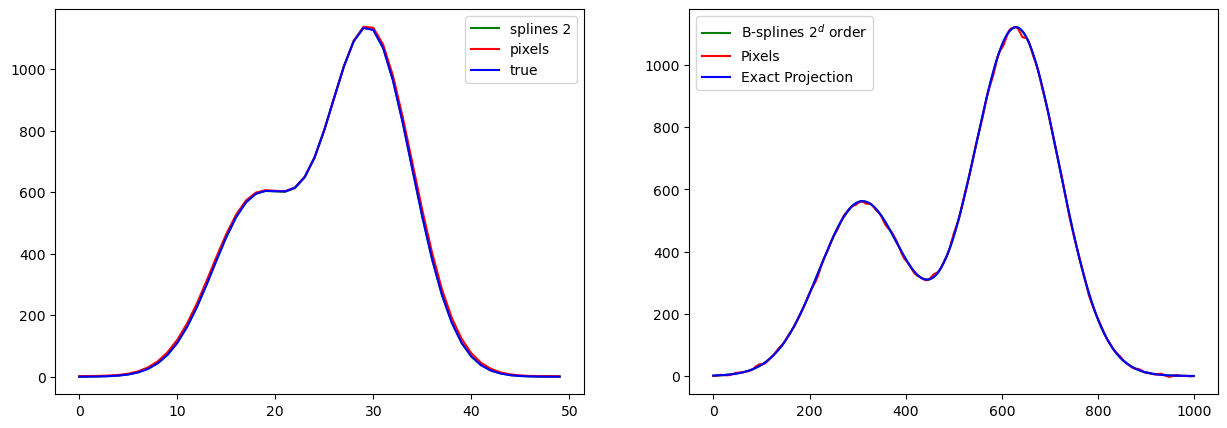

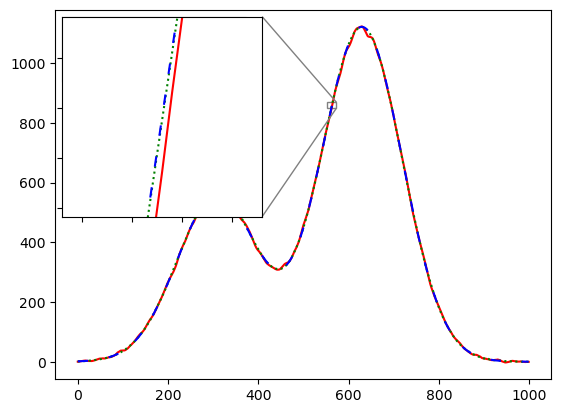

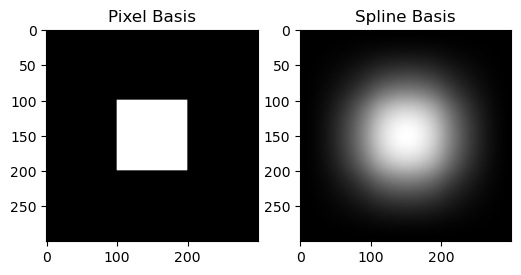

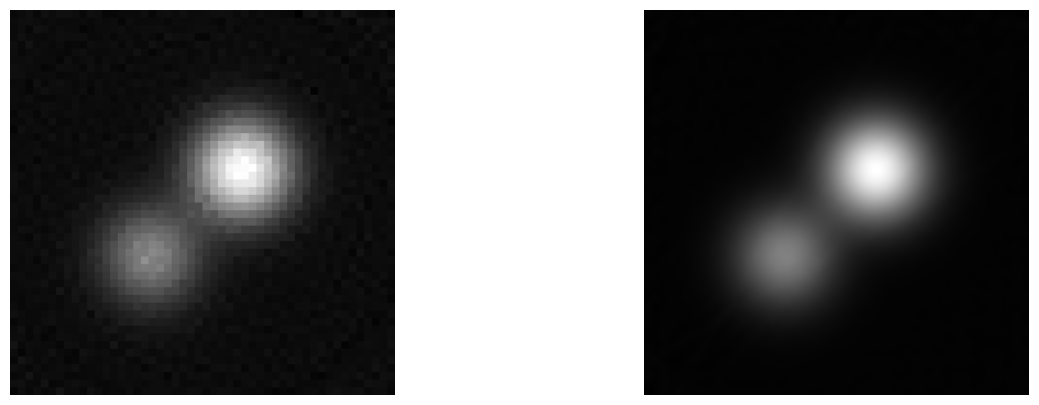

In [3]:
#interactive matplotlib backend

N_side = 5000 
phantom = create_phantom(N_side)

arg_shape = phantom.shape

pitch_op = (1.,1.) 
N_angle  = 30
N_offset = 50
op_pixels, op_splines_1, op_splines_2 = set_operators_parallel_beam(N_side, N_angle, N_offset, pitch_op, arg_shape)

N_offset_true = 1000
op_true, _, _ = set_operators_parallel_beam(N_side, N_angle, N_offset_true, pitch_op, arg_shape)

fwd_splines_1 = op_splines_1.apply(phantom.reshape(-1))
fwd_splines_2 = op_splines_2.apply(phantom.reshape(-1))
fwd_pixels = op_pixels.apply(phantom.reshape(-1))

y_data = fwd_pixels

fwd_splines_1 = fwd_splines_1.reshape((N_angle, N_offset)).get() 
fwd_splines_2 = fwd_splines_2.reshape((N_angle, N_offset)).get()
fwd_pixels = fwd_pixels.reshape((N_angle, N_offset)).get() 
sinogram_astra = fwd_pixels

stop_crit = pxst.MaxIter(30)

oversampling = 50
pitch_op = (phantom.shape[0]/oversampling, phantom.shape[0]/oversampling)
arg_shape = (oversampling, oversampling)
op_pixels, op_splines_1, op_splines_2 = set_operators_parallel_beam(N_side, N_angle, N_offset, pitch_op, arg_shape)

recon_pixels = op_pixels.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))
recon_box_1 = op_splines_1.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))
recon_box_2 = op_splines_2.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

#plt.figure('Phantom')
#plt.imshow(phantom, cmap='gray')
axes[0, 0].imshow(phantom.get(), cmap='gray')
axes[0, 0].set_title('Phantom')
#plt.figure('sino')
#plt.imshow(fwd_splines_1.reshape((N_angle, N_offset)).T, cmap='gray')
axes[0, 1].imshow(fwd_pixels.T, cmap='gray')
axes[0, 1].set_title('Sino pixels')

axes[0, 2].imshow(fwd_splines_2.T, cmap='gray')
axes[0, 2].set_title('Sino B-splines $2^d$ order')

#plt.figure('recon pix')
#plt.imshow(recon_pixels.get(), cmap='gray')
axes[1, 0].imshow(recon_pixels.get(), cmap='gray')
axes[1, 0].set_title('Reconstruction coeff Pixels')

#plt.figure('recon splines 1')
#plt.imshow(recon_box_1.get(), cmap='gray')
axes[1, 1].imshow(recon_box_1.get(), cmap='gray')
axes[1, 1].set_title('Reconstruction coeff B-splines $1^d$ order')

#plt.figure('recon splines 2')
plt.imshow(recon_box_2.get(), cmap='gray')
axes[1, 2].imshow(recon_box_2.get(), cmap='gray')
axes[1, 2].set_title('Reconstruction coeff B-splines $2^d$ order')

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
#plt.figure('fwd - recon')
fwd = op_splines_1.apply(recon_box_1.reshape(-1)).get()
fwd_splines = fwd.reshape((N_angle, N_offset))
#plt.plot(fwd_splines[0], c='green', label='splines 2')
axes[0].plot(fwd_splines[0], c='green', label='splines 2')
fwd = op_pixels.apply(recon_pixels.reshape(-1)).get()
fwd_pixels = fwd.reshape((N_angle, N_offset))
#plt.plot(fwd_pixels[0], c='red', label='pixels')
axes[0].plot(fwd_pixels[0], c='red', label='pixels')
true_proj = y_data.get().reshape((N_angle, N_offset))
#plt.plot(true_proj[0], c='blue', label='true')
axes[0].plot(true_proj[0], c='blue', label='true')
print('sample normal')
norm1 = np.linalg.norm(true_proj - fwd_splines)
print('norm diff splines : ', norm1)
norm2 = np.linalg.norm(true_proj - fwd_pixels)
print('norm diff pixels  : ', norm2)
axes[0].legend()

N_offset = 1000
op_pixels, op_splines_1, op_splines_2 = set_operators_parallel_beam(N_side, N_angle, N_offset_true, pitch_op, arg_shape)

#plt.figure('fwd - recon (many offsets)')
fwd = op_splines_2.apply(recon_box_2.reshape(-1)).get()
fwd_splines = fwd.reshape((N_angle, N_offset_true))
#plt.plot(fwd_splines[9], c='green', label='B-splines $2^d$ order')
axes[1].plot(fwd_splines[9], c='green', label='B-splines $2^d$ order')
fwd = op_pixels.apply(recon_pixels.reshape(-1)).get()
fwd_pixels = fwd.reshape((N_angle, N_offset_true))
#plt.plot(fwd_pixels[9], c='red', label='Pixels')
axes[1].plot(fwd_pixels[9], c='red', label='Pixels')
true_proj = op_true.apply(phantom.reshape(-1)).get()
true_proj = true_proj.reshape((N_angle, N_offset_true))
#plt.plot(true_proj[9], c='blue', label='Exact Projection')
axes[1].plot(true_proj[9], c='blue', label='Exact Projection')
#plt.legend()
axes[1].legend()

fig, ax = plt.subplots()
axins = inset_axes(ax, 2,2 , loc=2)

ax.plot(fwd_pixels[9], label='Pixels', c='red')
axins.plot(fwd_pixels[9], label='Pixels', c='red')

#dotted lines
ax.plot(fwd_splines[9], label='Quadratic B-splines', c='green', linestyle = 'dotted')
axins.plot(fwd_splines[9], label='Quadratic B-splines', c='green', linestyle = 'dotted')

#dashed lines
ax.plot(true_proj[9], label='Exact', c='blue', linestyle='--', dashes=(5, 10))
axins.plot(true_proj[9], label='Exact', c='blue', linestyle='--', dashes=(5, 10))

x_baseline = 563
y_true = true_proj[9][x_baseline]
x1, x2, y1, y2 = x_baseline-10, x_baseline+10, y_true-10, y_true+10
#505+10, 505+20, 1332-10, 1332+10 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits

plt.xticks(visible=False)
plt.yticks(visible=False)

mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5")
ax.legend()
plt.savefig('inset.eps', format='eps')

print('Oversampled')
norm1 = np.linalg.norm(true_proj - fwd_splines)
print('norm diff splines : ', norm1)
norm2 = np.linalg.norm(true_proj - fwd_pixels)
print('norm diff pixels  : ', norm2)

NN = phantom.shape[0]//oversampling
mini_im = np.zeros((3*NN, 3*NN))
mini_im_pix = mini_im
mini_im_spline = mini_im

rec_pix = recon_pixels.get()
rec_spline = recon_box_2.get()

mini_im_pix[NN:2*NN, NN:2*NN] = 1
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

ax[0].imshow(mini_im_pix, cmap='gray')
ax[0].set_title('Pixel Basis')

mini_im_spline = spconv(mini_im_pix, mini_im_pix[NN:2*NN, NN:2*NN], mode='same')
mini_im_spline = spconv(mini_im_spline, mini_im_pix[NN:2*NN, NN:2*NN], mode='same')

ax[1].imshow(mini_im_spline, cmap='gray')
ax[1].set_title('Spline Basis')

full_im_pix = np.zeros((phantom.shape[0] + 2*NN, phantom.shape[0] + 2*NN))
for i in range(oversampling):
    for j in range(oversampling):
        i_min, i_max, j_min, j_max = NN*i, NN*i+3*NN, NN*j, NN*j+3*NN
        full_im_pix[i_min : i_max, j_min:j_max] += mini_im_pix * rec_pix[i,j]

full_im_spline = np.zeros((phantom.shape[0] + 2*NN, phantom.shape[0] + 2*NN))
for i in range(oversampling):
    for j in range(oversampling):
        i_min, i_max, j_min, j_max = NN*i, NN*i+3*NN, NN*j, NN*j+3*NN
        full_im_spline[i_min : i_max, j_min:j_max] += mini_im_spline * rec_spline[i,j]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(full_im_pix[NN:-NN, NN:-NN], cmap='gray')
ax[1].imshow(full_im_spline[NN:-NN, NN:-NN], cmap='gray')
for a in ax:
    a.axis('off')
plt.savefig('upsampled.eps', format='eps')


print(np.linalg.norm(full_im_pix[NN:-NN, NN:-NN]/np.max(full_im_pix[NN:-NN, NN:-NN]) - phantom.get()))
print(np.linalg.norm(full_im_spline[NN:-NN, NN:-NN]/np.max(full_im_spline[NN:-NN, NN:-NN]) - phantom.get()))
plt.show()

In [4]:
import astra 

def run_xp(N_angle, N_offset, N_offset_true, oversampling):
    N_side = 5000 
    phantom = create_phantom(N_side)
    arg_shape = phantom.shape

    pitch_op = (1.,1.) 
    #N_angle  = 1000 
    #N_offset = 1000
    op_pixels, op_splines_1, op_splines_2 = set_operators_parallel_beam(N_side, N_angle, N_offset, pitch_op, arg_shape)

    #N_offset_true = 1000
    op_true, _, _ = set_operators_parallel_beam(N_side, N_angle, N_offset_true, pitch_op, arg_shape)

    fwd_splines_1 = op_splines_1.apply(phantom.reshape(-1))
    fwd_splines_2 = op_splines_2.apply(phantom.reshape(-1))
    fwd_pixels = op_pixels.apply(phantom.reshape(-1))

    #y_data = fwd_pixels
    angles = np.linspace(0, np.pi, N_angle, endpoint=False)
    vol_geom = astra.create_vol_geom(phantom.shape[0], phantom.shape[1])
    det_spacing = N_side/N_offset
    proj_geom = astra.create_proj_geom('parallel', det_spacing, N_offset, angles)
    proj_id = astra.create_projector('line', proj_geom, vol_geom)
    sinogram_id, y_data = astra.create_sino(np.array(phantom.get()), proj_id)
    y_data = cp.array(y_data).reshape(-1)

    fwd_splines_1 = fwd_splines_1.reshape((N_angle, N_offset)).get() 
    fwd_splines_2 = fwd_splines_2.reshape((N_angle, N_offset)).get()
    fwd_pixels = fwd_pixels.reshape((N_angle, N_offset)).get() 

    stop_crit = pxst.MaxIter(5)

    #oversampling = 50
    pitch_op = (phantom.shape[0]/oversampling, phantom.shape[0]/oversampling)
    arg_shape = (oversampling, oversampling)
    op_pixels, op_splines_1, op_splines_2 = set_operators_parallel_beam(N_side, N_angle, N_offset, pitch_op, arg_shape)

    recon_pixels = op_pixels.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))
    recon_box_1 = op_splines_1.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))
    recon_box_2 = op_splines_2.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))

    fwd = op_splines_1.apply(recon_box_1.reshape(-1)).get()
    fwd_splines = fwd.reshape((N_angle, N_offset))
    
    fwd = op_pixels.apply(recon_pixels.reshape(-1)).get()
    fwd_pixels = fwd.reshape((N_angle, N_offset))
    
    true_proj = y_data.get().reshape((N_angle, N_offset))
   
    op_pixels, op_splines_1, op_splines_2 = set_operators_parallel_beam(N_side, N_angle, N_offset_true, pitch_op, arg_shape)

    fwd = op_splines_2.apply(recon_box_2.reshape(-1)).get()
    fwd_splines = fwd.reshape((N_angle, N_offset_true))
    fwd = op_pixels.apply(recon_pixels.reshape(-1)).get()
    fwd_pixels = fwd.reshape((N_angle, N_offset_true))
    true_proj = op_true.apply(phantom.reshape(-1)).get()
    true_proj = true_proj.reshape((N_angle, N_offset_true))

    
    NN = phantom.shape[0]//oversampling
    mini_im = np.zeros((3*NN, 3*NN))
    mini_im_pix = mini_im
    mini_im_spline = mini_im

    rec_pix = recon_pixels.get()
    rec_spline = recon_box_2.get()

    mini_im_pix[NN:2*NN, NN:2*NN] = 1
    
    mini_im_spline = spconv(mini_im_pix, mini_im_pix[NN:2*NN, NN:2*NN], mode='same')
    mini_im_spline = spconv(mini_im_spline, mini_im_pix[NN:2*NN, NN:2*NN], mode='same')

    full_im_pix = np.zeros((phantom.shape[0] + 2*NN, phantom.shape[0] + 2*NN))
    print('begin oversampling')
    for i in range(oversampling):
        for j in range(oversampling):
            i_min, i_max, j_min, j_max = NN*i, NN*i+3*NN, NN*j, NN*j+3*NN
            full_im_pix[i_min : i_max, j_min:j_max] += mini_im_pix * rec_pix[i,j]

    full_im_spline = np.zeros((phantom.shape[0] + 2*NN, phantom.shape[0] + 2*NN))
    for i in range(oversampling):
        for j in range(oversampling):
            i_min, i_max, j_min, j_max = NN*i, NN*i+3*NN, NN*j, NN*j+3*NN
            full_im_spline[i_min : i_max, j_min:j_max] += mini_im_spline * rec_spline[i,j]

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].imshow(full_im_pix[NN:-NN, NN:-NN], cmap='gray')
    ax[1].imshow(full_im_spline[NN:-NN, NN:-NN], cmap='gray')
    
    for a in ax:
        a.axis('off')
    #plt.savefig('upsampled.eps', format='eps')

    loss1 = psnr(phantom.get()/np.max(phantom.get()), full_im_pix[NN:-NN, NN:-NN]/np.max(full_im_pix[NN:-NN, NN:-NN]))
    loss2 = psnr(phantom.get()/np.max(phantom.get()), full_im_spline[NN:-NN, NN:-NN]/np.max(full_im_spline[NN:-NN, NN:-NN]))
    plt.show()

    return loss1, loss2


In [5]:
oversamplings = [20, 25, 40, 50, 100, 125, 200, 250, 500, 1000, 1250]

losses1 = []
losses2 = []
for oversampling in oversamplings:
    print('Oversampling : ', oversampling)
    loss1, loss2 = run_xp(1000, 1000, 1000, oversampling)
    losses1.append(loss1)
    losses2.append(loss2)

plt.figure('Losses')
plt.plot(oversamplings, losses1, label='Pixels')
plt.plot(oversamplings, losses2, label='B-splines')
plt.scatter(oversamplings, losses1)
plt.scatter(oversamplings, losses2)
plt.legend()
plt.show()

Oversampling :  20
